In [1]:
from edward.models import Normal, Categorical, Bernoulli, Deterministic
import edward as ed
import tensorflow as tf
import numpy as np
% matplotlib inline
from matplotlib import pyplot as plt
#from tqdm import tqdm

c:\Anaconda36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Load CNN-produced Features

In [2]:
# these were produced by running predict() on the convolutional network
x_train = np.load('feats_train.npy')
x_test = np.load('feats_test.npy')
x_train.shape

(8034, 1536)

In [3]:
x_train.min(), x_train.max()

(0.0, 2.5375211)

In [4]:
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_train.shape

(8034, 2)

## Build a 3-layer Dense Bayesian Neural Network in Edward

In [5]:
ed.set_seed(42)
N = 100  # batch size
D = 1536  # feature count
D1 = 512 # layer 1 width
D2 = 64 # layer 2 width
K = 2   # class count

In [6]:
# Create placeholder for data
x = tf.placeholder(tf.float32, [None, D])

# layer 1
# Normal(0,1) priors
w_1 = Normal(loc=tf.zeros([D,D1]), scale=tf.ones([D,D1]))
b_1 = Normal(loc=tf.zeros(D1), scale=tf.ones(D1))
h_1 = tf.nn.tanh(tf.matmul(x,w_1)+b_1)

# layer 2
w_2 = Normal(loc=tf.zeros([D1,D2]), scale=tf.ones([D1,D2]))
b_2 = Normal(loc=tf.zeros(D2), scale=tf.ones(D2))
h_2 = tf.nn.tanh(tf.matmul(h_1,w_2)+b_2)

# layer 2
w_3 = Normal(loc=tf.zeros([D2,K]), scale=tf.ones([D2,K]))
b_3 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
h_3 = Deterministic(tf.nn.softmax(tf.matmul(h_2,w_3)+b_3))

# categorical likelihood for classification
y = Categorical(probs=h_3)

In [7]:
# construct q(w) and q(b) assuming normal distributions
qw_1 = Normal(loc=tf.Variable(tf.random_normal([D,D1])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([D,D1]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([D1])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([D1]))))

qw_2 = Normal(loc=tf.Variable(tf.random_normal([D1,D2])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([D1,D2]))))
qb_2 = Normal(loc=tf.Variable(tf.random_normal([D2])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([D2]))))

qw_3 = Normal(loc=tf.Variable(tf.random_normal([D2,K])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([D2,K]))))
qb_3 = Normal(loc=tf.Variable(tf.random_normal([K])),
           scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [8]:
# placeholder for labels
y_ph = tf.placeholder(tf.int32, [N])
# define variational inference technique, ie minimizze KL-divergence between q and p
inference = ed.KLqp({w_1: qw_1, b_1: qb_1,
                     w_2: qw_2, b_2: qb_2,
                     w_3: qw_3, b_3: qb_3}, data={y: y_ph})

In [9]:
# initialize inference variables
inference.initialize(n_iter=15000, n_print=1000, scale={y: y_train.shape[0] / N})

In [10]:
# use interactive tf session
sess = tf.InteractiveSession()
# initializze all variables in the session
tf.global_variables_initializer().run()

In [11]:
# start training
for i in range(inference.n_iter):
    batch_id = i*N % 8000
    X_batch = x_train[batch_id:batch_id+N]
    y_batch = y_train[batch_id:batch_id+N]
    # convert one-hot encoding to single label
    y_batch = np.argmax(y_batch, axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: y_batch})
    inference.print_progress(info_dict)

15000/15000 [100%] ██████████████████████████████ Elapsed: 64s | Loss: 5155.466


In [12]:
saver = tf.train.Saver()
save_path = saver.save(sess, './edward_model.ckpt')
print('Model saved to {}'.format(save_path))

Model saved to ./edward_model.ckpt


In [13]:
# convert one-hot into a single label.
Y_test = np.argmax(y_test,axis=1)

In [14]:
y_post = ed.copy(y, {w_1: qw_1, b_1: qb_1,
                     w_2: qw_2, b_2: qb_2,
                     w_3: qw_3, b_3: qb_3})

In [15]:
ed.evaluate('binary_accuracy', data={x: x_test, y_post: Y_test})

c:\Anaconda36\lib\site-packages\edward\util\random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
c:\Anaconda36\lib\site-packages\edward\util\random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


0.8361329

##### We see that Edward has achieved similar test accuracy to the standard neural network we already trained.

0.836 above, and 0.843 for the traditional neural network

## Evaluate performance

In [16]:
y_prob = ed.copy(h_3, {w_1: qw_1, b_1: qb_1,
                     w_2: qw_2, b_2: qb_2,
                     w_3: qw_3, b_3: qb_3})

In [17]:
# generate posterior predictive samples

def sample_predict(n_samples=5000):

    # hold samples here
    samples = np.empty((n_samples,len(x_test),2))
    
    # tqdm breaks Edwards pbar :(
    pbar = ed.util.Progbar(n_samples)
    
    # the naive way would be to pass a shape to sample() but this
    # will not return the desires result. We have to loop.
    for i in range(n_samples):
        samples[i] = y_prob.sample().eval(feed_dict={x: x_test})
        pbar.update(i+1)
    
    # if the universe has not yet experienced heat death, return samples
    return samples

In [330]:
sample_42 = sample_predict()

5000/5000 [100%] ██████████████████████████████ Elapsed: 8327s


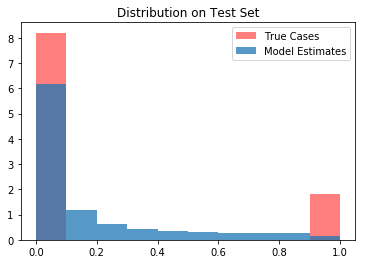

In [240]:
plt.hist(y_test[:,1], density=True, alpha=0.5, color='r', label='True Cases')
plt.hist(sample_42[:,:,1].ravel(), bins=10, density=True, alpha=0.75, label='Model Estimates')
plt.legend()
plt.title('Distribution on Test Set');

The distribution of samples across the entire test data indicates that the network is rather uncertain, placing a lot of mass in the middle area.

In [332]:
np.save('test_samples_5k.npy', sample_42)

In [334]:
stds = sample_42.std(axis=0)
stds.shape

(2679, 2)

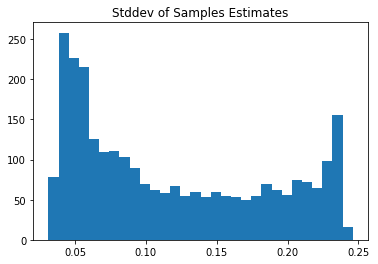

In [335]:
plt.hist(stds[:,0], bins=30)
plt.title('Stddev of Samples Estimates');

There is a fairly large range of standard deviations. There are some images on which the network is very confident. It does seem that our sampling is succesfully producing an indication of uncertainty.

In [336]:
np.argmax(stds[:,0])

1378

In [337]:
stds[1378]

array([0.24607726, 0.24607726])

In [338]:
sample_42[:,1378,1].min(), sample_42[:,1378,1].max()

(2.7953357857768424e-05, 0.9953585267066956)

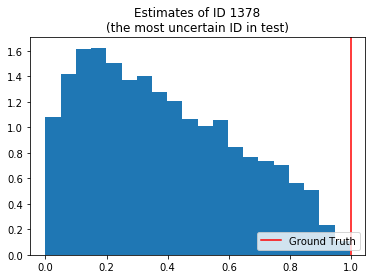

In [339]:
plt.hist(sample_42[:,1378,1], bins=20, density=True)
plt.title('Estimates of ID 1378\n(the most uncertain ID in test)')
plt.axvline(1, c='r', label='Ground Truth')
plt.legend(loc='lower right');

In [340]:
pct_1 = np.sum(sample_42[:,:,1]>0.01, axis=0) / len(sample_42)

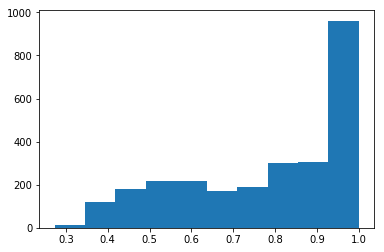

In [341]:
plt.hist(pct_1);

### Evaluate ROC Curve for comparison to traditional model

In [314]:
from sklearn.metrics import roc_curve, auc

In [342]:
# define dict for data
roc_data = dict()

# tqdm breaks Edwards pbar :(
pbar = ed.util.Progbar(100)

# iterate over each percent
for i in np.arange(0, 1, 0.01):
    
    # get percent of samples above cutoff
    if np.sum(sample_42[:,:,1]>i) > 0:
        pct_above = np.sum(sample_42[:,:,1]*(sample_42[:,:,1]>i), axis=0) / np.sum(sample_42[:,:,1]>i)
    else:
        pct_above = 0
    
    # calculate roc 
    fpr, tpr, _ = roc_curve(Y_test, pct_above)
    
    # calculate auc
    roc_auc = auc(fpr, tpr)
    
    # store
    roc_data[i] = dict(fpr=fpr, tpr=tpr, auc=roc_auc)
    
    pbar.update(i*100+1)

100/100 [100%] ██████████████████████████████ Elapsed: 13s


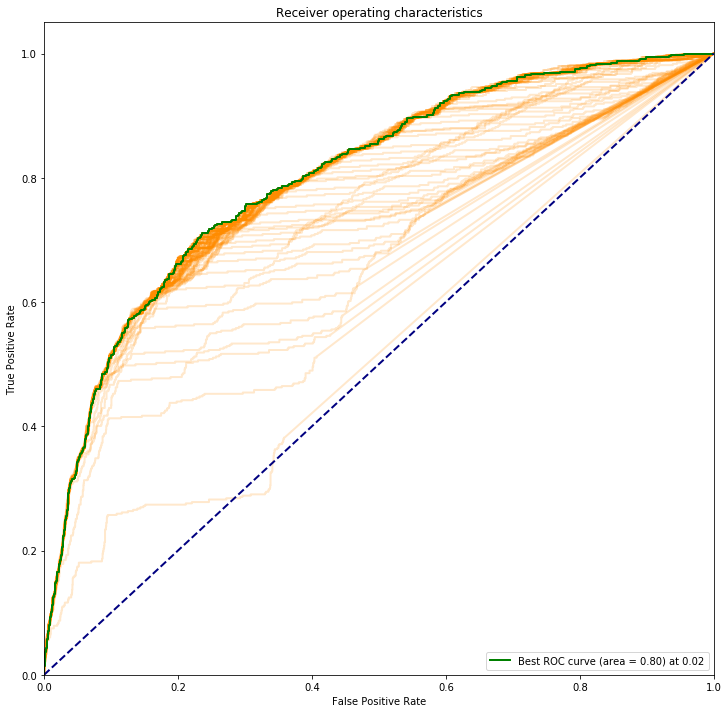

In [343]:
plt.figure(figsize=(12,12))
lw = 2

best_auc = 0.0
best_fpr_tpr = []
best_i = 0

for i in roc_data.keys():
    fpr = roc_data[i]['fpr']
    tpr = roc_data[i]['tpr']
    auc_ = roc_data[i]['auc']

    if auc_ > best_auc:
        best_auc = auc_
        best_fpr_tpr = (fpr,tpr)
        best_i = i
    
    plt.plot(fpr, tpr, color='darkorange', lw=lw, alpha=0.2)
    
plt.plot(*best_fpr_tpr, color='g', lw=lw, alpha=1,
         label='Best ROC curve (area = {:.2f}) at {}'.format(best_auc, best_i))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc='lower right');

With many samples, we can sum all samples above some threshold probability to get a new point estimate. We see that setting a threshold of nearly 0 (which simplifies to computing the mean) results in the best ROC curve, and that the resulting ROC curve is nearly identical to that achieved with the non-bayesian network. For the purpose of providing a single classification, the Bayesian neural network does not yield a change in accuracy.

## Save Samples for Visualization

In [18]:
x_all = np.load('feats_all.npy')

In [23]:
# generate posterior predictive samples

def sample_predict_on_data(x_data, n_samples=2000):
    
    # hold samples here
    samples = np.empty((n_samples,len(x_data),2))
    
    # tqdm breaks Edwards pbar :(
    pbar = ed.util.Progbar(n_samples)
    
    # the naive way would be to pass a shape to sample() but this
    # will not return the desires result. We have to loop.
    for i in range(n_samples):
        samples[i] = y_prob.sample().eval(feed_dict={x: x_data})
        pbar.update(i+1)
    
    # if the universe has not yet experienced heat death, return samples
    return samples

In [24]:
all_samples = sample_predict_on_data(x_all)

2000/2000 [100%] ██████████████████████████████ Elapsed: 929s


In [25]:
np.save('samples_all.npy', all_samples)